In [1]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [1]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

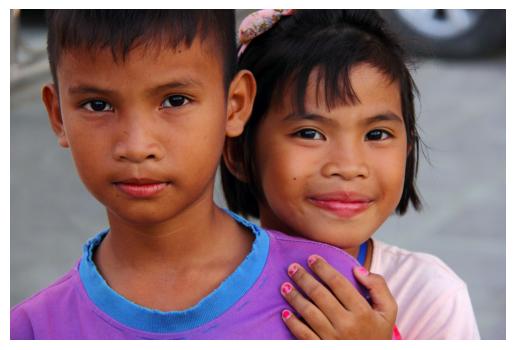

In [2]:
import cv2
import matplotlib.pyplot as plt

# Descargar la imagen
IMAGE_FILE = "image.jpg"
!curl -s -o {IMAGE_FILE} https://i.imgur.com/Vu2Nqwb.jpeg

# Cargar la imagen
img = cv2.imread(IMAGE_FILE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para que los colores sean correctos en matplotlib

# Mostrar la imagen con matplotlib
plt.imshow(img)
plt.axis("off")  # Ocultar los ejes
plt.show()


In [3]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import time

I0000 00:00:1746563060.442448     483 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1746563060.445353     711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


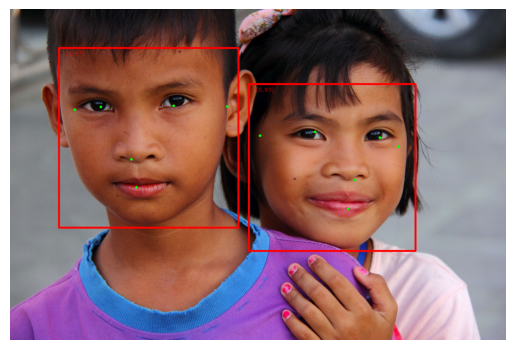

Tiempo de deteccion de rostro en 0.0018336772918701172 segundos


In [6]:
# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
def proccess_img(img_path):
    image = mp.Image.create_from_file(img_path)
    
    inicio_tiempo = time.time()
    # STEP 4: Detect faces in the input image.
    detection_result = detector.detect(image)
    elapsed_tiempo = time.time() - inicio_tiempo
    
    # STEP 5: Process the detection result. In this case, visualize it.
    image_copy = np.copy(image.numpy_view())
    annotated_image = visualize(image_copy, detection_result)
    # rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    plt.imshow(annotated_image)
    plt.axis("off")  # Ocultar los ejes
    plt.show()
    
    return elapsed_tiempo

elapsed_tiempo = proccess_img(IMAGE_FILE)
print(f"Tiempo de deteccion de rostro en {elapsed_tiempo} segundos")

Procesando ./crop/man2_person0.jpg...


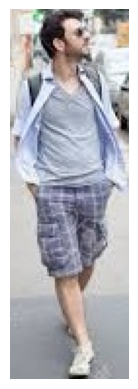

Procesando ./crop/image_person1.jpg...


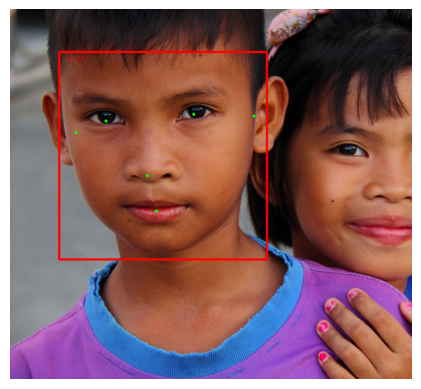

Procesando ./crop/man4_person1.jpg...


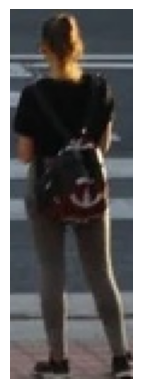

Procesando ./crop/obama_person0.jpg...


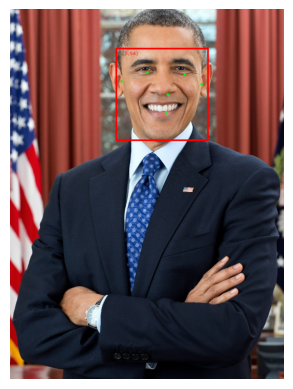

Procesando ./crop/man3_person0.jpg...


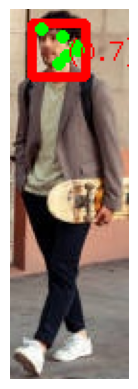

Procesando ./crop/biden_person0.jpg...


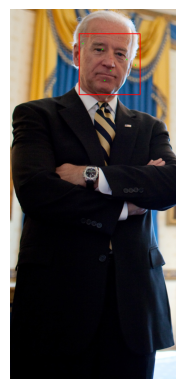

Procesando ./crop/man4_person0.jpg...


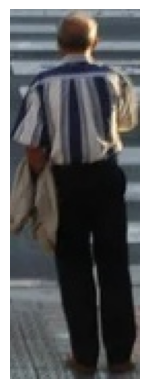

Procesando ./crop/man5_person2.jpg...


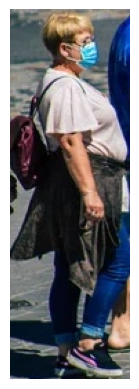

Procesando ./crop/man5_person3.jpg...


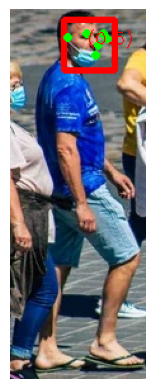

Procesando ./crop/obama2_person0.jpg...


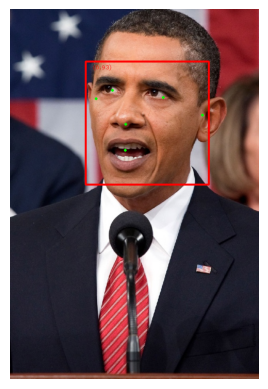

Procesando ./crop/man5_person1.jpg...


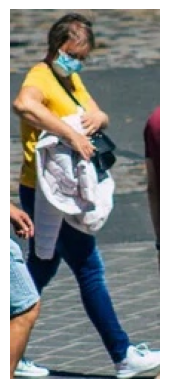

Procesando ./crop/man7_person0.jpg...


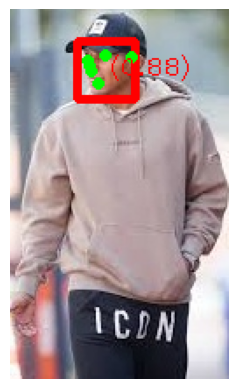

Procesando ./crop/man4_person4.jpg...


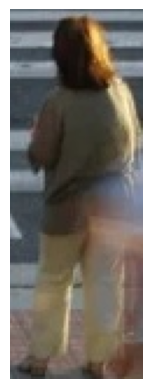

Procesando ./crop/man4_person2.jpg...


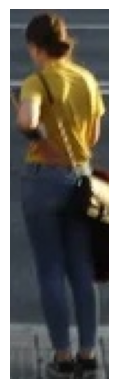

Procesando ./crop/man5_person0.jpg...


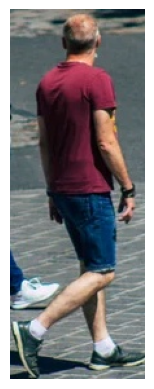

Procesando ./crop/man1_person0.jpg...


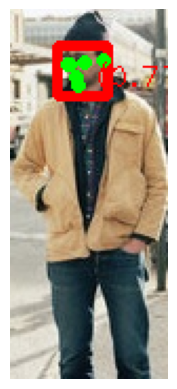

Procesando ./crop/man4_person5.jpg...


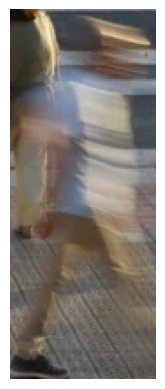

Procesando ./crop/alex-lacamoire_person0.jpg...


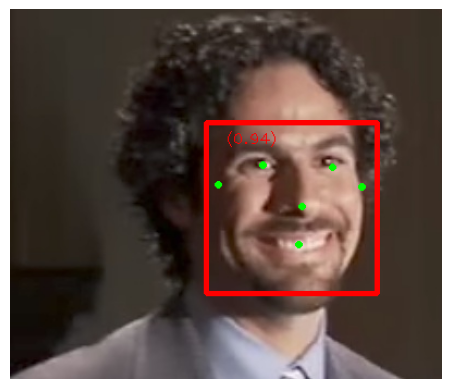

Procesando ./crop/image_person0.jpg...


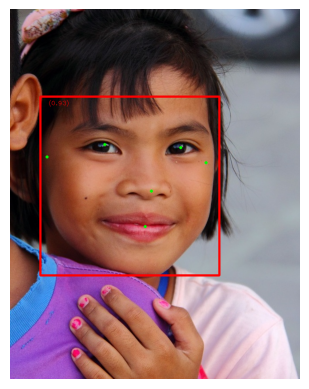

19 imagenes. Tiempo promedio de deteccion de rostro 0.002085296731246145 segundos


In [10]:
import os

# Define la ruta de la carpeta que contiene las imágenes
image_folder = './crop'  # Reemplaza con la ruta de tu carpeta
list_elpased_time = []
# Itera sobre los archivos de la carpeta
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        print(f"Procesando {image_path}...")
        elpased_time = proccess_img(image_path)  # Primer cuadro: detección y bounding boxes
        list_elpased_time.append(elpased_time)
promedio = sum(list_elpased_time) / len(list_elpased_time)
print(f"{len(os.listdir(image_folder))} imagenes. Tiempo promedio de deteccion de rostro {promedio} segundos")